<a href="https://colab.research.google.com/github/AtrCheema/dl4seq/blob/master/examples/hyper_para_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyper parameter optimization
This file describes how to do hyper parameter optimization of machine learningand deep learning algorithms using
`HyperOpt` module of `dl4seq` package. In this file, random search, grid search Bayesian methods are implemented.

In [1]:
# install dl4seq package if it is nto available already
try:
    from dl4seq import Model
except ImportError:
    !python -m pip install git+https://github.com/AtrCheema/dl4seq.git@exp

  Cloning https://github.com/AtrCheema/dl4seq.git to /tmp/pip-req-build-rsqzi8k_
  Running command git clone -q https://github.com/AtrCheema/dl4seq.git /tmp/pip-req-build-rsqzi8k_
     |████████████████████████████████| 102kB 5.5MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
  Created wheel for dl4seq: filename=dl4seq-1.0-cp36-none-any.whl size=167751 sha256=53f2ce06a81945c6852b564630fd4b6ae2158f93c6be3bb87c8c5c5b7a2a4d26
  Stored in directory: /tmp/pip-ephem-wheel-cache-tdyr8c38/wheels/58/b3/dd/04cbdb7326d155a4ec3bfdbbeb2d294beb90c56faad5b13105
Successfully built dl4seq


In [2]:
from dl4seq import Model
from dl4seq.utils import make_model
from dl4seq.hyper_opt import HyperOpt
from dl4seq.data import load_30min

from skopt.space import Real, Categorical, Integer
import numpy as np


**********Pytorch models could not be imported **********



Read the data file. Our data contains 1446 rows nad 24 columns.

In [3]:
data = load_30min()
data.shape

(1446, 23)

In [4]:
data.head()

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,...,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
Date_Time2,,,,,,,,,,,,,,,,,,,,,
2018-06-19 00:00:00,36.407149,19.321232,33.956059,19.780000,0.0,0.0,159.533333,0.960000,1002.856667,1007.256667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-19 00:30:00,35.562515,19.320124,33.950508,19.093333,0.0,0.0,86.596667,0.163333,1002.300000,1006.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-19 01:00:00,34.808016,19.319666,33.942532,18.733333,0.0,0.0,2.260000,0.080000,1001.973333,1006.373333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-19 01:30:00,30.645216,19.320406,33.931263,18.760000,0.0,0.0,62.710000,0.193333,1001.776667,1006.120000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-19 02:00:00,26.608980,19.326729,33.917961,18.633333,0.0,0.0,63.446667,0.510000,1001.743333,1006.103333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Define which columns in the data are to be used as inputs and which columns are to be used as outputs. 


In [5]:
inputs = ['input1', 'input2', 'input3', 'input4', 'input5', 'input6', 'input8',  'input11']
outputs = ['target5']

Let's first use [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_api.html) model with some random parameters which go in `ml_model_args`.

In [6]:
dl4seq_args = {"inputs": inputs,
               "outputs": outputs,
               "val_data": "same",
               "ml_model": "xgboostregressor", 
               "test_fraction": 0.3}

These and other hyper parameters go into `make_model` function which returns model's configuration as `config` dictioanry. This `config` is then used to initiate the `Model`.

# Grid Search
Define the parameter space.

In [7]:
dims = {'n_estimators': [1000, 1200, 1400, 1600, 1800,  2000],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001,  0.0005],
        'booster': ["gbtree", "dart"]}        

In [8]:
opt = HyperOpt("grid",
               param_space=dims,
               dl4seq_args=dl4seq_args,
               data=data,
               use_named_args=True,
               )

total number of iterations: 288


c:\users\user\anaconda3\envs\tfcpu231_py38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neural_network.multilayer_perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neural_network. Anything that cannot be imported from sklearn.neural_network is now part of the private API.
  warnings.warn(message, FutureWarning)


Validation mse 0.868447
Validation mse 0.868448
Validation mse 0.86845
Validation mse 0.868451
Validation mse 0.868451
Validation mse 0.868451
Validation mse 0.869858
Validation mse 0.869856
Validation mse 0.869855
Validation mse 0.869855
Validation mse 0.869854
Validation mse 0.869854
Validation mse 0.955551
Validation mse 0.955551
Validation mse 0.955551
Validation mse 0.955551
Validation mse 0.955551
Validation mse 0.955551
Validation mse 0.890331
Validation mse 0.890331
Validation mse 0.890331
Validation mse 0.890331
Validation mse 0.89033
Validation mse 0.89033
Validation mse 0.8466
Validation mse 0.844974
Validation mse 0.845352
Validation mse 0.845356
Validation mse 0.845357
Validation mse 0.845358
Validation mse 0.827377
Validation mse 0.827375
Validation mse 0.827374
Validation mse 0.827372
Validation mse 0.827371
Validation mse 0.82737
Validation mse 0.929519
Validation mse 0.929519
Validation mse 0.92952
Validation mse 0.929521
Validation mse 0.929521
Validation mse 0.929522

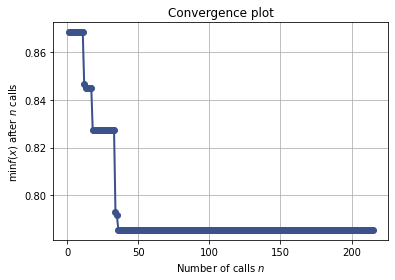

In [9]:
sr = opt.fit()

In [10]:
opt.best_paras

{'booster': 'dart',
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 1400}

building ML layer based model for regression problem

********** Removing Samples with nan labels  **********

input_X shape: (151, 8)
prev_Y shape: (151, 1)
label shape: (151,)

********** Removing Samples with nan labels  **********

input_X shape: (65, 8)
prev_Y shape: (65, 1)
label shape: (65,)
o here 0 <class 'numpy.int32'>
Validation mse 0.785364


0.785364

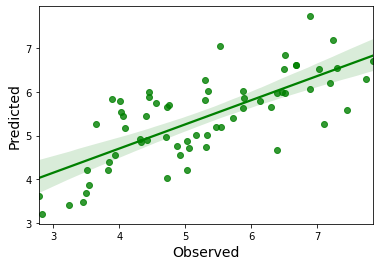

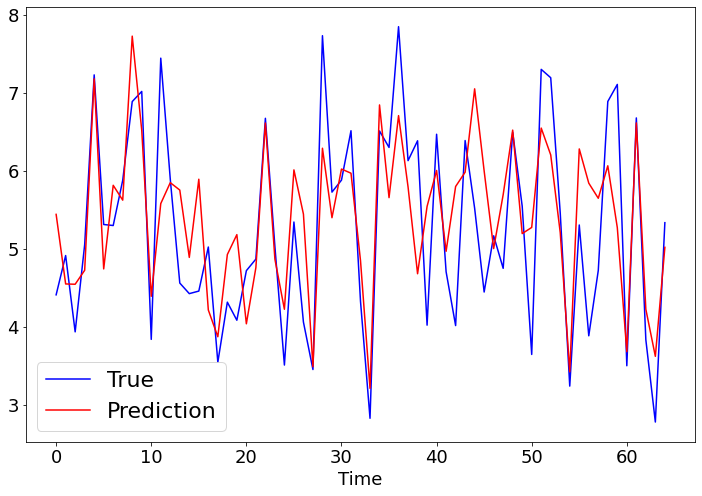

In [11]:
opt.predict(**opt.best_paras)

# Random Search

Now we will use `random search` algorithm for hyper parameter optimization. The most important parameter is `n_iter` 
which determines how many iterations we are going to use. 

total number of iterations: 100
Validation mse 0.87001
Validation mse 0.890331
Validation mse 0.869239
Validation mse 0.827837
Validation mse 0.785364
Validation mse 0.941411
Validation mse 0.983551
Validation mse 0.801727
Validation mse 1.295216
Validation mse 0.803023
Validation mse 0.890327
Validation mse 0.943627
Validation mse 0.845356
Validation mse 0.873014
Validation mse 0.947238
Validation mse 0.935388
Validation mse 0.808557
Validation mse 0.800227
Validation mse 1.168216
Validation mse 0.890327
Validation mse 0.860576
Validation mse 0.801165
Validation mse 1.158854
Validation mse 0.929516
Validation mse 0.997156
Validation mse 0.955551
Validation mse 1.341312
Validation mse 0.869855
Validation mse 0.846977
Validation mse 0.953828
Validation mse 1.269533
Validation mse 0.953828
Validation mse 1.095303
Validation mse 0.860624
Validation mse 0.939941
Validation mse 0.890331
Validation mse 1.229411
Validation mse 1.043727
Validation mse 0.860003
Validation mse 0.84506
Validation

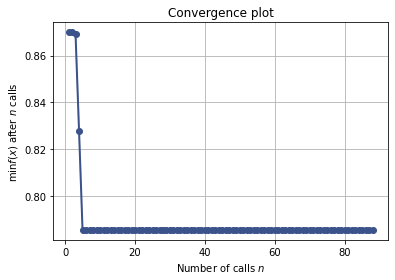

In [12]:
opt = HyperOpt("random",
               param_space=dims,
               dl4seq_args=dl4seq_args,
               data=data,
               use_named_args=True,
               n_iter=100
               )
sr = opt.fit()

In [13]:
#Find the best parameters
opt.best_paras

{'n_estimators': 1400,
 'max_depth': 3,
 'learning_rate': 0.01,
 'booster': 'gbtree'}

building ML layer based model for regression problem

********** Removing Samples with nan labels  **********

input_X shape: (151, 8)
prev_Y shape: (151, 1)
label shape: (151,)

********** Removing Samples with nan labels  **********

input_X shape: (65, 8)
prev_Y shape: (65, 1)
label shape: (65,)
o here 0 <class 'numpy.int32'>
Validation mse 0.785364


0.785364

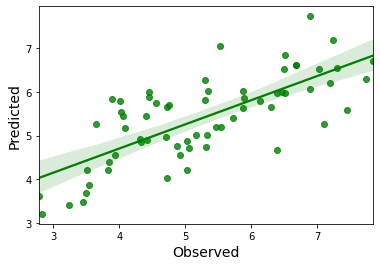

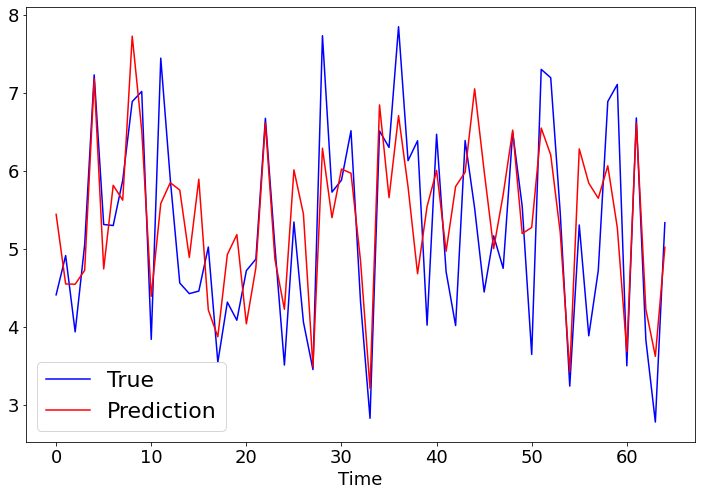

In [14]:
# make prediction using best parameters.
opt.predict(**opt.best_paras)

# Bayesian
Now we optimize the same parameters with `Bayesian` optimization. Under the hood, we use [`gp_minimize`](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt.gp_minimize) function of [`skopt`](https://scikit-optimize.github.io/stable/index.html).

We first need to define the parameter space. But since we are going to use skopt, we need to define the parameter space 
using space classes available from skopt. The parameter space can be [`Integer`](https://scikit-optimize.github.io/stable/modules/generated/skopt.space.space.Integer.html#skopt.space.space.Integer), [`Real`](https://scikit-optimize.github.io/stable/modules/generated/skopt.space.space.Real.html#skopt.space.space.Real) or [`Categorical`](https://scikit-optimize.github.io/stable/modules/generated/skopt.space.space.Categorical.html#skopt.space.space.Categorical) depending upon the parameter.

In [15]:
dims = [Integer(low=1000, high=2000, name='n_estimators'),
        Integer(low=3, high=6, name='max_depth'),
        Real(low=1e-5, high=0.1, name='learning_rate'),
        Categorical(categories=["gbtree", "dart"], name="booster")
        ]

We need to initiate the `HyperOpt` class same as above. All the additional parameters which we want to pass `gp_minimize`
can be passed to `HyperOpt` class. Finally we use `fit` method to start optimization. 

Validation mse 0.792831
Validation mse 0.898675
Validation mse 0.853088
Validation mse 0.944724
Validation mse 1.77969
Validation mse 0.890327
Validation mse 1.788448
Validation mse 0.940955
Validation mse 0.879873
Validation mse 0.897937
Validation mse 0.850674
Validation mse 0.971347
Validation mse 0.822751
Validation mse 0.948879
Validation mse 0.802401
Validation mse 0.815571
Validation mse 0.852695
Validation mse 0.860694
Validation mse 0.888124
Validation mse 0.82911
Validation mse 0.848991
Validation mse 0.832588
Validation mse 0.84438
Validation mse 0.841441
Validation mse 0.807329
Validation mse 0.804456
Validation mse 0.891908
Validation mse 0.868451
Validation mse 0.815201
Validation mse 0.824979
Validation mse 0.829119
Validation mse 0.885289
Validation mse 0.817396
Validation mse 0.808857
Validation mse 0.83304
Validation mse 0.792384
Validation mse 0.844592
Validation mse 0.810221
Validation mse 0.868523
Validation mse 0.813109
Validation mse 0.804322
Validation mse 0.840

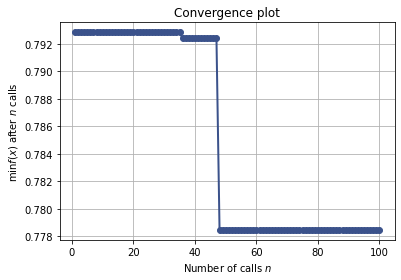

In [16]:
opt = HyperOpt("bayes",
               param_space=dims,
               dl4seq_args=dl4seq_args,
               data=data,
               use_named_args=True,
               n_calls=100,
               x0=[1000, 3, 0.01, "gbtree"],
               n_random_starts=3,  # the number of random initialization points
               random_state=2
               
               )
sr = opt.fit()

# Bayesian with LSTM model

Now we build and [`LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) based model and optimize its parameters with Bayesian optimization method. The `layers` dictionary is used to define the structure of the neural network. 

In [18]:
layers = {
    "LSTM": {"config": {"units": 64}},
    "Dense": {"config": {"units": 1, "activation": "relu"}},
    "Reshape": {"config": {"target_shape": (1,1)}}
}

dl4seq_args = {"inputs": inputs,
               "outputs": outputs,
               "lookback": 4,
               "val_data": "same",
               "test_fraction": 0.3,
               "layers": layers,
               "epochs": 500
               }
# make model args
config = make_model(**dl4seq_args)

#initiate the mdoel
model = Model(config, data=data, verbosity=0)

train the model while randomly splitting train and test data.

In [19]:
history = model.train(indices="random")

D:\mytools\dl4seq\dl4seq\main.py:732: UserWarning: Setting val_fraction from 0.2 to 0.0
  warnings.warn(f"Setting val_fraction from {self.data_config['val_fraction']} to 0.0")


In [20]:
# The minimum validation loss acheived during training
np.min(history.history['val_loss'])

0.013944599777460098

o here 0 <class 'numpy.int32'>


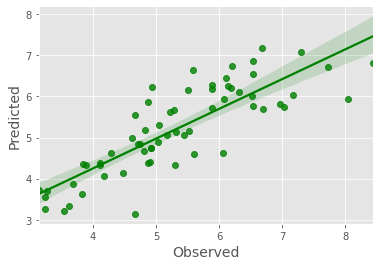

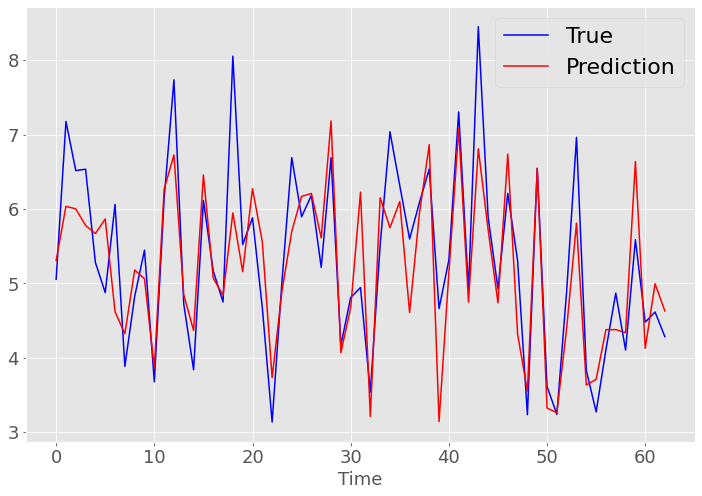

In [21]:
# Perfomance on validation data
t,p = model.predict(indices=model.test_indices)

Now in order to optimize the parameters define parameter space for the parameters to be optimized

In [22]:
from skopt.space import Real, Categorical, Integer

dims = [Categorical([32, 64, 128, 256], name='lstm_units'),
        Integer(low=3, high=12, name='lookback'),
        Real(low=1e-5, high=0.01, name='learning_rate'),
        Categorical(categories=[8, 12, 16, 24, 32], name="batch_size"),
        Categorical(categories=["relu", "elu", "leakyrelu"], name="dense_actfn")
        ]

Define objective function. The parameters to be optimized (which have been declared above) will be in kwargs. We can use them in our objective function as we like.

In [9]:
def objective_fn(return_model=False,
                 title="bayes", # This will make sure that all optimization results will be stored in a single folder
                 **kwargs):

    layers = {
        "LSTM": {"config": {"units": int(kwargs["lstm_units"])}},
        "Dense": {"config": {"units": 1, "activation": kwargs["dense_actfn"]}},
        "Reshape": {"config": {"target_shape": (1,1)}}
    }

    config = make_model(
        inputs=inputs,
        outputs=outputs,
        lookback=int(kwargs["lookback"]),
        val_data="same",
        val_fraction=0.0,
        test_fraction=0.3,
        layers=layers,
        batch_size=int(kwargs["batch_size"]),
        lr=float(kwargs["learning_rate"]),
        epochs=500)

    model = Model(config,
                  data=data,
                  prefix=title,
                  verbosity=0)

    history = model.train(indices="random")

    mse = np.min(history.history['val_loss'])
    print(f"Validation mse {mse}")

    if return_model:
        return model
    return mse

Initiatialize optimization problem. Since we are using the external function/model and not `dl4seq`, we need to provide 
the objective function/model/function as keyword argument `model`. The remaming parameters are same as above and they 
which will be passed to [`gp_minimize`](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt.gp_minimize).

In [ ]:
opt = HyperOpt("bayes",
               model=objective_fn,
               param_space=dims,
               use_named_args=True,
               acq_func='EI',  # Expected Improvement.
               n_calls=50,     #number of iterations
               # acq_optimizer='auto',
               x0=[32, 5, 0.001, 8, "relu"],  # inital value of optimizing parameters
               n_random_starts=3,  # the number of random initialization points
               random_state=2
               )

Start optimization

D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.014554675668478012


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.00983125064522028


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.016472168266773224


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.012076866813004017


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.01449171919375658


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.013450190424919128


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.021607713773846626


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.016823293641209602


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.017797887325286865


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.017567619681358337


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.014095905236899853


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.009520284831523895


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.013527403585612774


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.010824999772012234


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.02802572026848793


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.02270890586078167


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008832384832203388


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008834959007799625


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.009609134867787361


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.010378307662904263


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008147969841957092


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.030761685222387314


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.006128933746367693


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.01820727437734604


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008837660774588585


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.0071402788162231445


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.018661674112081528


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.014240553602576256


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.013465716503560543


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.015939220786094666


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.015326252207159996


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.0385909304022789


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.011450686492025852


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.018805278465151787


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008689222857356071


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.007652265019714832


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.01973297819495201


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.012371945194900036


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008114762604236603


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.010205377824604511


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.007287687622010708


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.029271243140101433


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.020707622170448303


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.012186756357550621


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.0077107441611588


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008861803449690342


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.010330649092793465


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.011318990960717201


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.010030483826994896


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008163606747984886
could not pickle results


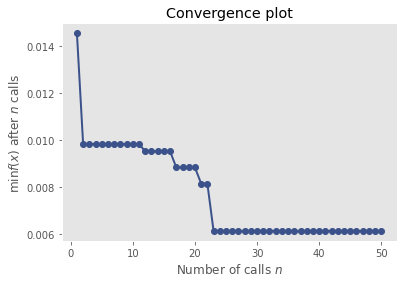

In [ ]:
opt_results = opt.fit()

The optimized value of objective function will be the lowest mse achieved during model's iterations.

In [ ]:
opt.gpmin_results['fun']

0.006128933746367693

And the parameters which produced this (best) value are

In [ ]:
opt.best_paras

[128, 12, 0.00391297699511148, 24, 'elu']

Now we can train the LSTM model with the best parameters

In [10]:
model = objective_fn(return_model=True, title=None,
                    lstm_units=128, lookback=12, learning_rate=0.00391297699511148, batch_size=24, dense_actfn="elu")

Validation mse 0.006128933746367693


o here [0.21194598] <class 'numpy.ndarray'>


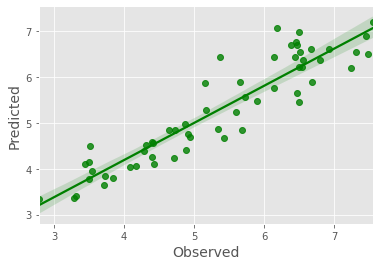

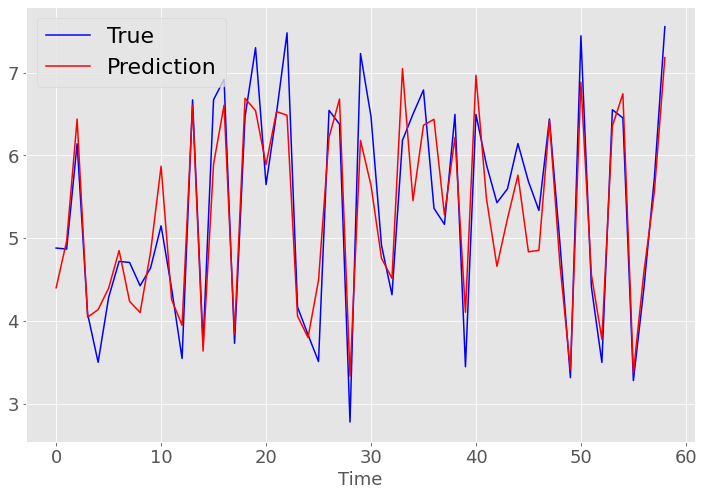

In [12]:
# Perfomance on validation data
t,p_test = model.predict(indices=model.test_indices)

o here 0 <class 'numpy.int32'>


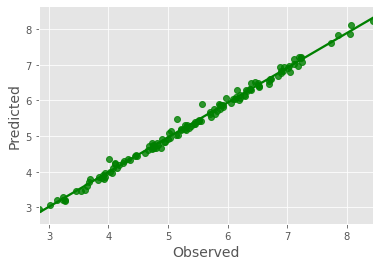

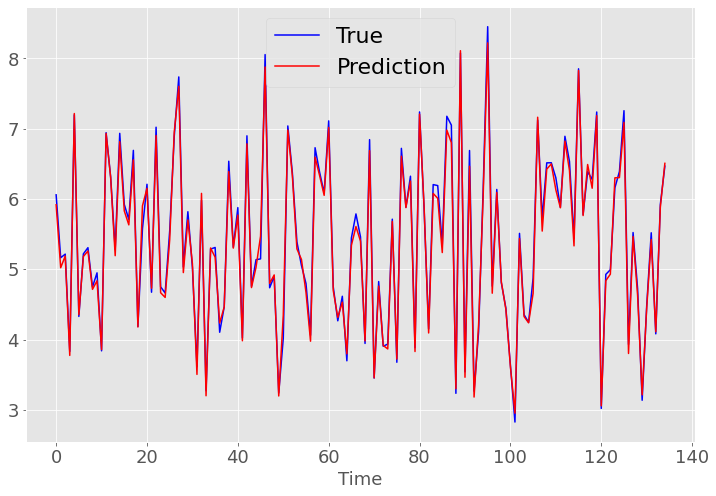

In [26]:
# Performance of the model on training data
t,p = model.predict(indices=model.train_indices, pref='train')

currently we are ignoring examples where the corresponding labels are NaNs. We can check this.

In [27]:
model.data_config['ignore_nans']

False

The above argument means that for an example/sample if nans are found in its target/label, then don't ignore nan, 
rather skip that example. This is the reason, our trainig data was of about 155 examples and test/validation data
consisted of about 68 examples. 

At prediction time, we would however, like to check model's peformance on all the data irrespective of the fact whether 
labels are available or not. When labels are not available, we will not be able to caculate corresponding errors but the
model is able to make predictions on that data.

In [28]:
model.data_config['ignore_nans'] = True
model.data_config['ignore_nans']

True


********** Ignoring NANs in predictions **********



c:\users\user\anaconda3\envs\tfcpu231_py38\lib\site-packages\TSErrors\TSErrors.py:1312: UserWarning: Row(s) [   0    1    2 ... 1432 1433 1434] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


o here 0 <class 'numpy.int32'>


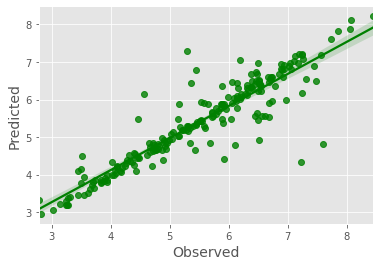

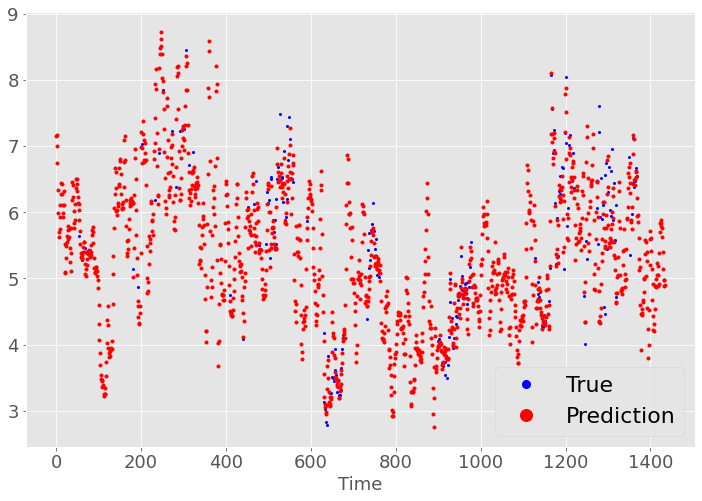

In [29]:
# Performance of the model on training data
t,p = model.predict(pref='all')

In [30]:
# The results with the best model are  are saved in following folder.
model.path

'D:\\mytools\\dl4seq\\examples\\results\\20201211_135845'

# Optimizing multiple models
Because of simplified user interfaces of `dl4seq` and `HyperOpt`, we can now optimize hyper-parameters of multiple models/functions
with relatively few lines of code. For example if we want to optimize parameters of [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and 
[SupportVectorRessor](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), we can do following.

Validation mse 20.906884
Validation mse 1.209681
Validation mse 1.209681
Validation mse 1.209681
Validation mse 1.209681
Validation mse 1.209681
Validation mse 1.209681
Validation mse 1.209681
Validation mse 1.209681
Validation mse 1.209681
Validation mse 1.209681
Validation mse 1.612242
Validation mse 1.209764
Validation mse 1.206861
Validation mse 1.167755


c:\users\user\anaconda3\envs\tfcpu231_py38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Validation mse 1.167755
Validation mse 1.361486
Validation mse 1.387586
Validation mse 1.898767
Validation mse 1.898767
Validation mse 0.706309
Validation mse 0.623381
Validation mse 0.706309
Validation mse 0.623381


c:\users\user\anaconda3\envs\tfcpu231_py38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Validation mse 0.623381
could not pickle results
Evaluting model's performance on best set of parameters.
building ML based model for regression problem

********** Removing Samples with nan labels  **********

input_X shape: (151, 8)
prev_Y shape: (151, 1)
label shape: (151,)

********** Removing Samples with nan labels  **********

input_X shape: (65, 8)
prev_Y shape: (65, 1)
label shape: (65,)
o here [0.16717502] <class 'numpy.ndarray'>
Validation mse 0.623381

********** Removing Samples with nan labels  **********

input_X shape: (151, 8)
prev_Y shape: (151, 1)
label shape: (151,)
o here [0.15578716] <class 'numpy.ndarray'>

********** Removing Samples with nan labels  **********

input_X shape: (218, 8)
prev_Y shape: (218, 1)
label shape: (218,)
o here [0.15978203] <class 'numpy.ndarray'>
Evaluting model's performance on best set of parameters.


D:\mytools\dl4seq\dl4seq\utils\plotting_tools.py:399: UserWarning: for rbf kernels of SVR, feature importance can not be plotted.
  warnings.warn(f"for {self._model.kernel} kernels of {self.model_cofig['ml_model']}, feature importance can not be plotted.")


building ML based model for regression problem

********** Removing Samples with nan labels  **********

input_X shape: (151, 8)
prev_Y shape: (151, 1)
label shape: (151,)

********** Removing Samples with nan labels  **********

input_X shape: (65, 8)
prev_Y shape: (65, 1)
label shape: (65,)
o here [0.16717502] <class 'numpy.ndarray'>
Validation mse 0.623381

********** Removing Samples with nan labels  **********

input_X shape: (151, 8)
prev_Y shape: (151, 1)
label shape: (151,)
o here [0.15578716] <class 'numpy.ndarray'>

********** Removing Samples with nan labels  **********

input_X shape: (218, 8)
prev_Y shape: (218, 1)
label shape: (218,)
o here [0.15978203] <class 'numpy.ndarray'>

********** Removing Samples with nan labels  **********

input_X shape: (65, 8)
prev_Y shape: (65, 1)
label shape: (65,)


D:\mytools\dl4seq\dl4seq\utils\plotting_tools.py:399: UserWarning: for rbf kernels of SVR, feature importance can not be plotted.
  warnings.warn(f"for {self._model.kernel} kernels of {self.model_cofig['ml_model']}, feature importance can not be plotted.")


Validation mse 1.016243
Validation mse 1.010688
Validation mse 1.089227
Validation mse 0.971168
Validation mse 1.089227
Validation mse 0.971168
Validation mse 1.089227
Validation mse 0.971168
Validation mse 1.089227
Validation mse 0.971168
Validation mse 1.089227


c:\users\user\anaconda3\envs\tfcpu231_py38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Validation mse 0.971168
Validation mse 0.959795
Validation mse 0.94433
Validation mse 0.94772
Validation mse 0.952674
Validation mse 0.920155
Validation mse 0.922992


c:\users\user\anaconda3\envs\tfcpu231_py38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Validation mse 0.920155


c:\users\user\anaconda3\envs\tfcpu231_py38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Validation mse 0.920155


c:\users\user\anaconda3\envs\tfcpu231_py38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Validation mse 0.920155


c:\users\user\anaconda3\envs\tfcpu231_py38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Validation mse 0.920155
Validation mse 0.926843


c:\users\user\anaconda3\envs\tfcpu231_py38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Validation mse 0.920155


c:\users\user\anaconda3\envs\tfcpu231_py38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Validation mse 0.920155
could not pickle results
Evaluting model's performance on best set of parameters.
building ML based model for regression problem

********** Removing Samples with nan labels  **********

input_X shape: (151, 8)
prev_Y shape: (151, 1)
label shape: (151,)

********** Removing Samples with nan labels  **********

input_X shape: (65, 8)
prev_Y shape: (65, 1)
label shape: (65,)
o here [0.16481907] <class 'numpy.ndarray'>
Validation mse 0.920155

********** Removing Samples with nan labels  **********

input_X shape: (151, 8)
prev_Y shape: (151, 1)
label shape: (151,)
o here [0.16964964] <class 'numpy.ndarray'>

********** Removing Samples with nan labels  **********

input_X shape: (218, 8)
prev_Y shape: (218, 1)
label shape: (218,)
o here [0.16811067] <class 'numpy.ndarray'>
Evaluting model's performance on best set of parameters.
building ML based model for regression problem

********** Removing Samples with nan labels  **********

input_X shape: (151, 8)
prev_Y s

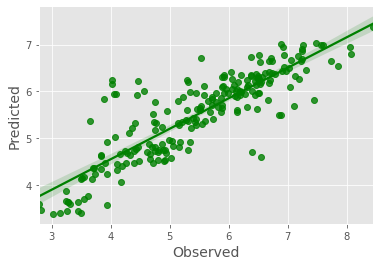

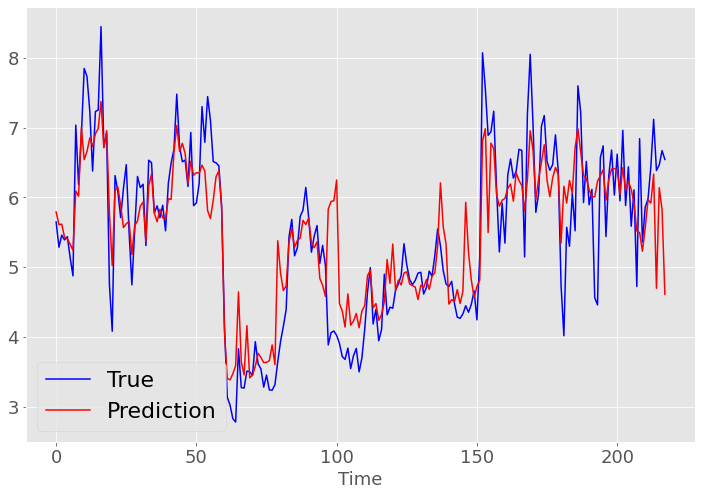

In [13]:
dims = {"SVR": {"dims":
               [Categorical(categories=[0.1, 0.2, 0.3, 0.4, 0.5], name='epsilon'),
                Integer(low=3, high=6, name='degree'),
                Real(low=1.0, high=2.0, name='C'),
                Categorical(categories=["linear", "poly", "rbf", "sigmoid"], name="kernel")],
                "x0": [0.2, 3, 1.5, "sigmoid"]},

        "RandomForestRegressor":
        {"dims":
         [Categorical(categories=[100, 300, 500, 700, 900, 1100], name="n_estimators"),
          Integer(low=3, high=6, name='max_depth'),
          Integer(low=2, high=5, name='min_samples_split'),
          Integer(low=1, high=4, name='min_samples_leaf')],
         "x0": [300, 4, 3, 3]}
     }

# container for saving the results.
results = {}

for model, paras in dims.items():

    opt = HyperOpt("bayes",
                   param_space=paras['dims'],
                   dl4seq_args= {"inputs": inputs,
                                 "outputs": outputs,
                                 "val_data": "same",
                                 "ml_model": model,
                                 "test_fraction": 0.3},
                   data=data,
                   eval_on_best=True,
                   n_calls=25,
                   use_named_args=True,
                   x0=paras["x0"]
                   )

    sr = opt.fit()
    _model = opt.eval_with_best(return_model=True)
    results[model] = _model.predict(indices=_model.test_indices, pp=False)
    

By adding more models in `dims` dictionary above, we optimize parameters of more models.

We can compare the performance of two models using [Taylor's diagram](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2000JD900719).

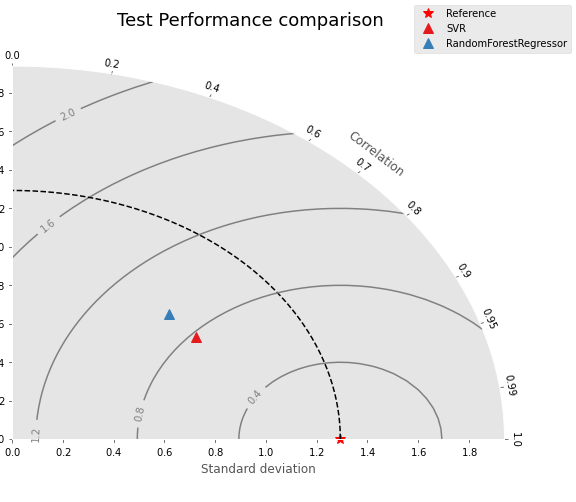

In [17]:
from dl4seq.utils.taylor_diagram import plot_taylor

trues = {'Test': results["RandomForestRegressor"][0]}

simulations = {"Test": {
    "SVR": results["SVR"][1],
    "RandomForestRegressor": results["RandomForestRegressor"][1],
}}

rects = {
    "Test": 111
}

import matplotlib.pyplot as plt
plt.close('all')
plot_taylor(trues=trues,
            simulations=simulations,
            rects=rects,
            add_grid=True,
            plot_bias=True,
            figsize=(9,7),
            title="Test Performance comparison")